In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load your GPU telemetry CSV
df = pd.read_csv("gpu_telemetry_extended.csv")

print(df.head())
print(df.info())


                 timestamp  temperature.gpu  power.draw power.limit  \
0  2026/02/05 00:12:43.189               66       13.16       [N/A]   
1  2026/02/05 00:12:44.277               66       13.98       [N/A]   
2  2026/02/05 00:12:45.347               66       13.16       [N/A]   
3  2026/02/05 00:12:46.418               66       13.20       [N/A]   
4  2026/02/05 00:12:47.478               66       13.15       [N/A]   

   utilization.gpu  utilization.memory  memory.used  memory.total  clocks.gr  \
0                5                   1         1322          4096       1575   
1                5                   1         1322          4096       1575   
2                5                   1         1322          4096       1575   
3                5                   1         1322          4096       1575   
4                5                   1         1322          4096       1575   

   clocks.mem fan.speed pstate  
0        7000     [N/A]     P0  
1        7000     [N/A]   

In [3]:

df.replace("[N/A]", np.nan, inplace=True)

# Convert numeric columns
for col in df.columns:
    if col not in ["timestamp", "pstate"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop columns with many missing values
df.drop(columns=["fan.speed", "power.limit"], errors="ignore", inplace=True)

df = df.dropna()
df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_23664\2226612587.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("[N/A]", np.nan, inplace=True)


,timestamp,temperature.gpu,power.draw,utilization.gpu,utilization.memory,memory.used,memory.total,clocks.gr,clocks.mem,pstate
0,2026/02/05 00:12:43.189,66,13.16,5,1,1322,4096,1575,7000,P0
1,2026/02/05 00:12:44.277,66,13.98,5,1,1322,4096,1575,7000,P0
2,2026/02/05 00:12:45.347,66,13.16,5,1,1322,4096,1575,7000,P0
3,2026/02/05 00:12:46.418,66,13.20,5,1,1322,4096,1575,7000,P0
4,2026/02/05 00:12:47.478,66,13.15,5,1,1322,4096,1575,7000,P0


In [4]:
df["memory_ratio"] = df["memory.used"] / df["memory.total"]
df["temp_delta"] = df["temperature.gpu"].diff()
df["power_delta"] = df["power.draw"].diff()
df["util_rolling_mean"] = df["utilization.gpu"].rolling(30).mean()

df = df.dropna()
df.head()


,timestamp,temperature.gpu,power.draw,utilization.gpu,utilization.memory,memory.used,memory.total,clocks.gr,clocks.mem,pstate,memory_ratio,temp_delta,power_delta,util_rolling_mean
29,2026/02/05 00:13:14.185,68,16.25,24,3,1322,4096,1575,7000,P0,0.322754,0.0,0.32,16.833333
30,2026/02/05 00:13:15.254,68,16.21,23,3,1322,4096,1575,7000,P0,0.322754,0.0,-0.04,17.433333
31,2026/02/05 00:13:16.314,68,16.07,23,3,1322,4096,1575,7000,P0,0.322754,0.0,-0.14,18.033333
32,2026/02/05 00:13:17.382,68,16.29,23,3,1322,4096,1575,7000,P0,0.322754,0.0,0.22,18.633333
33,2026/02/05 00:13:18.459,67,17.00,20,3,1322,4096,1575,7000,P0,0.322754,-1.0,0.71,19.133333


In [5]:
FEATURES = [
    "temperature.gpu",
    "power.draw",
    "utilization.gpu",
    "utilization.memory",
    "memory_ratio",
    "clocks.gr",
    "clocks.mem",
    "temp_delta",
    "power_delta",
    "util_rolling_mean"
]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[FEATURES])


In [6]:
SEQUENCE_LENGTH = 30  # 30 seconds

X = []
for i in range(len(scaled_data) - SEQUENCE_LENGTH):
    X.append(scaled_data[i:i + SEQUENCE_LENGTH])

X = np.array(X)

print("LSTM input shape:", X.shape)


LSTM input shape: (2161, 30, 10)


In [7]:
model = Sequential([
    LSTM(64, activation="relu", input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    RepeatVector(X.shape[1]),
    LSTM(64, activation="relu", return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 10)              │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,874 (206.54 KB)

 Trainable params: 52,874 (206.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X, X,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0875 - val_loss: 0.0382
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0204 - val_loss: 0.0229
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0155 - val_loss: 0.0209
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0145 - val_loss: 0.0202
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0140 - val_loss: 0.0190
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0136 - val_loss: 0.0183
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0130 - val_loss: 0.0172
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0127 - val_loss: 0.0175
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0124 - val_loss: 0.0161
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - val_loss: 0.0159
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - val_loss: 0.0162
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

In [9]:
X_pred = model.predict(X)

reconstruction_error = np.mean(np.square(X - X_pred), axis=(1, 2))

threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

print("Anomaly threshold:", threshold)
print("Number of anomalies detected:", anomalies.sum())


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Anomaly threshold: 0.020322509521201373
Number of anomalies detected: 108


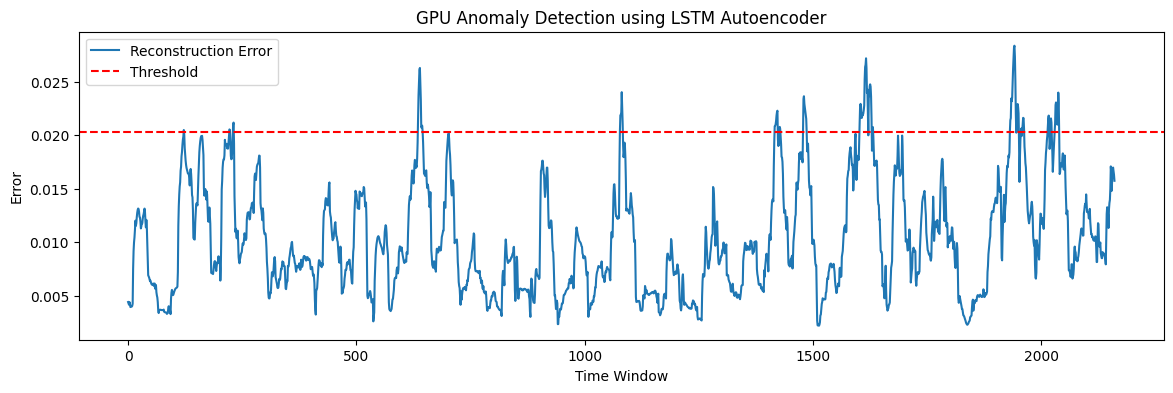

In [10]:
plt.figure(figsize=(14,4))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("GPU Anomaly Detection using LSTM Autoencoder")
plt.xlabel("Time Window")
plt.ylabel("Error")
plt.show()
